# Child-Friendly Gemma 3 Fine-Tuning (Training Only)

- Load the base `google/gemma-3-4b-it` chat model.
- Gather and normalize child-safe training data.
- Fine-tune with parameter-efficient LoRA/QLoRA settings on a single T4 GPU.
- Skip benchmarks and toxicity evaluations; focus on producing a LoRA adapter.


## Quick start
- Install dependencies from the bundled `requirements.txt`.
- Load the base Gemma 3 model and datasets used for training.
- Run the training cell to produce the LoRA adapter under `gemma3_child_friendly_lora`.
- Compare the base vs. fine-tuned responses on a child-like prompt.


In [1]:
import sys
import torch

print(f"Python version: {sys.version}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected'}")
!pip install -q -r requirements.txt
import importlib  # allow dynamic imports after installation
reloaded_packages = ["torch", "transformers", "datasets", "accelerate", "trl", "peft", "bitsandbytes", "pandas", "matplotlib"]
for pkg in reloaded_packages:
    globals()[pkg] = importlib.import_module(pkg)
    version = getattr(globals()[pkg], "__version__", "N/A")
    print(f"{pkg} version: {version}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CUDA available: True
CUDA device: Tesla T4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.8 MB/s eta 0:00:00
torch version: 2.9.0+cu126
transformers version: 4.57.2
datasets version: 4.0.0
accelerate version: 1.12.0
trl version: 0.25.1
peft version: 0.18.0
bitsandbytes version: 0.48.2
pandas version: 2.2.2
matplotlib version: 3.10.0


In [2]:
!pip install -U bitsandbytes

In [3]:
import random  # set random seeds
import numpy as np  # numerical operations for seeding
import os  # environment access
from huggingface_hub import login  # login helper for Hugging Face
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN') or "YOUR_HF_TOKEN"  # placeholder token
if hf_token and hf_token != "YOUR_HF_TOKEN":  # login only when provided
    login(token=hf_token)  # authenticate to Hugging Face
    os.environ["HF_TOKEN"] = hf_token  # ensure dataset downloads can reuse the token
    print("Logged in to Hugging Face using HF_TOKEN from Colab secrets.")
else:
    raise ValueError("Set HF_TOKEN in Colab secrets or replace YOUR_HF_TOKEN with your token.")

config = {  # central configuration dictionary
    "model_id": "google/gemma-3-4b-it",  # base Gemma 3 chat model
    "seed": 17,  # reproducibility seed
    "train_batch_size": 1,  # per-device train batch size for T4
    "eval_batch_size": 1,  # per-device eval batch size
    "gradient_accumulation_steps": 8,  # steps to reach effective batch size 8
    "learning_rate": 2e-4,  # learning rate for LoRA training
    "max_steps": 800,
    "logging_steps": 25,  # log interval
    "save_steps": 800,  # save only at the end
    "max_seq_length": 2048,  # input length cap
    "text_field": "text",  # field name for formatted text
    "source_field": "source"  # field name for provenance
}  # end of configuration

random.seed(config["seed"])  # seed Python RNG
np.random.seed(config["seed"])  # seed numpy RNG
torch.manual_seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["seed"])


Logged in to Hugging Face using HF_TOKEN from Colab secrets or fallback.


In [4]:
from transformers import AutoProcessor, BitsAndBytesConfig, Gemma3ForConditionalGeneration  # model and quantization classes

try:
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16  # choose dtype based on hardware
    bnb_config = BitsAndBytesConfig(  # set 4-bit quantization to fit T4
        load_in_4bit=True,  # enable 4-bit loading
        bnb_4bit_quant_type="nf4",  # use nf4 quantization
        bnb_4bit_use_double_quant=True,  # double quantization for stability
        bnb_4bit_compute_dtype=dtype  # computation dtype
    )  # end BitsAndBytesConfig
    base_processor = AutoProcessor.from_pretrained(config["model_id"])
    base_model = Gemma3ForConditionalGeneration.from_pretrained(
        config["model_id"],  # model repository id
        device_map="auto",  # automatically place layers on available devices
        quantization_config=bnb_config,  # apply 4-bit config
        torch_dtype=dtype  # set computation dtype
    )
    base_model.eval()  # switch to eval mode
    print("Loaded base Gemma 3 model for inference.")  # confirmation message
except Exception as load_error:  # handle loading issues
    print(f"Model load failed: {load_error}")
    raise  # re-raise to show stack trace

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Loaded base Gemma 3 model for inference.


In [5]:
from datasets import load_dataset, concatenate_datasets
import re  # regex utilities
from collections import Counter  # quick source distribution without pandas

seed = config["seed"]  # reuse configured seed

sahar_ds = load_dataset("hma96/SAHAR-Dataset", split="train")
sahar_pattern = re.compile(r"sahar", re.IGNORECASE)  # pattern to find/replace


def count_sahar_mentions(dataset):
    count = 0  # initialize counter
    for row in dataset:
        for field in ["input_history", "target_response"]:  # fields to scan
            text = row.get(field, "")  # fetch text
            if isinstance(text, str):  # ensure string input
                count += len(sahar_pattern.findall(text))  # add matches
    return count  # total occurrences


sahar_before = count_sahar_mentions(sahar_ds)  # count before replacement
print(f"[SAHAR] 'sahar' occurrences before: {sahar_before}")  # log count


def replace_sahar(example):  # replace occurrences in SAHAR fields
    updated = {}  # container for updated fields
    for field in ["input_history", "target_response"]:
        text = example.get(field, "")  # get field
        if isinstance(text, str):  # ensure string
            updated[field] = sahar_pattern.sub("chatbud", text)  # replace with chatbud
        else:
            updated[field] = text  # keep original
    return updated


sahar_clean = sahar_ds.map(replace_sahar)  # apply replacement
sahar_after = count_sahar_mentions(sahar_clean)  # recount after replacement
print(f"[SAHAR] 'sahar' occurrences after: {sahar_after}")  # log post count


def sahar_to_chat(example):  # convert SAHAR to unified chat
    user_text = example.get("input_history", "")  # user input history
    assistant_text = example.get("target_response", "")  # assistant target
    messages = [  # build chat turns
        {"role": "user", "content": user_text},  # user message
        {"role": "assistant", "content": assistant_text}  # assistant response
    ]  # end messages
    return {"messages": messages, "source": "sahar"}  # standardized example


sahar_chat = sahar_clean.map(sahar_to_chat, remove_columns=sahar_clean.column_names)  # map to chat format
print("[SAHAR] sample messages:", sahar_chat[0]["messages"])  # confirm replacement
print(
    "[SAHAR] chatbud present:",
    any("chatbud" in str(part.get("content", "")).lower() for part in sahar_chat[0]["messages"])
)  # verify replacement

child_ds = load_dataset("chaitanyareddy0702/Child-QA-dataset")
print(child_ds)
print("Child-QA train sample:", child_ds["train"].select(range(2)))  # preview first two train examples
print("Child-QA test sample:", child_ds["test"].select(range(2)))

child_train = child_ds["train"]  # focus on training split
question_candidates = ["Question", "question", "input", "prompt"]  # possible question fields
answer_candidates = ["Answer", "answer", "output", "response"]  # possible answer fields
question_field = next(
    (c for c in question_candidates if c in child_train.column_names),
    child_train.column_names[0]
)  # pick first match
answer_field = next(
    (c for c in answer_candidates if c in child_train.column_names),
    child_train.column_names[-1]
)  # pick first match


def child_to_chat(example):  # convert Child-QA schema to chat
    question = example.get(question_field, "")  # read question text
    answer = example.get(answer_field, "")  # read answer text
    messages = [  # build chat pair
        {"role": "user", "content": question},  # user question
        {"role": "assistant", "content": answer}  # assistant answer
    ]  # end messages
    return {"messages": messages, "source": "child_qa"}  # standardized example


child_chat = child_train.map(child_to_chat, remove_columns=child_train.column_names)  # process Child-QA
print(f"[Child-QA] size: {len(child_chat)}")  # log size
print("[Child-QA] sample messages:", child_chat[0]["messages"])  # show sample

cai_ds = load_dataset("HuggingFaceH4/cai-conversation-harmless")
print(cai_ds)
# Fix: Change 'train' to 'train_sft' or 'train_prefs' to access an existing split
cai_split = cai_ds["train_sft"]  # use the supervised finetuning split
cai_sample = cai_split.shuffle(seed=seed).select(range(min(1000, len(cai_split))))  # sample ~1000 rows with seed
# Fix: Changed "train" to "train_sft" for the cai_ds dataset as "train" split does not exist
cai_chat = cai_sample.map(
    lambda ex: {"messages": ex.get("messages", ex.get("conversations", [])), "source": "cai_harmless"}
)
print(f"[CAI] sampled size: {len(cai_chat)}")  # log cai sample size
print("[CAI] sample messages:", cai_chat[0]["messages"][:2])  # preview a couple messages

# Safe-Child block: kept for reference but fully commented out
# (we are no longer using The-Responsible-AI-Initiative/Safe_Child_LLM_Benchmark)
#     None
# )  # detect prompt column
#     c for c in safe_columns
# ]  # potential responses
#
#
#     )  # filter age 7-12
#
#                 {"role": "user", "content": user_prompt},  # user
#                 {"role": "assistant", "content": safe_reply}  # assistant safe reply
#             ]  # end messages
#
#             safe_child_to_chat,
#         )  # map to chat

kids_ds = load_dataset("yotev27367/KidsChatBot", split="train")
print(kids_ds)  # display KidsChatBot summary
print("KidsChatBot columns:", kids_ds.column_names)  # log KidsChatBot columns


def kids_chatbot_to_chat(example):  # convert KidsChatBot schema to chat
    question = example.get("Question", example.get("question", ""))  # read question text
    answer = example.get("Answer", example.get("answer", ""))  # read answer text
    messages = [  # build chat pair
        {"role": "user", "content": question},  # user question
        {"role": "assistant", "content": answer}  # assistant answer
    ]  # end messages
    return {"messages": messages, "source": "kids_chatbot"}  # standardized example


kids_chatbot_chat = kids_ds.map(
    kids_chatbot_to_chat,
    remove_columns=kids_ds.column_names
)  # process KidsChatBot
print(f"[KidsChatBot] size: {len(kids_chatbot_chat)}")  # log size (should be all rows)
print("[KidsChatBot] sample messages:", kids_chatbot_chat[0]["messages"])  # preview sample

prosocial_ds = load_dataset("allenai/prosocial-dialog", split="train")
risky_labels = {  # labels that need caution/intervention
    "__possibly_needs_caution__",
    "__probably_needs_caution__",
    "__needs_caution__",
    "__needs_intervention__",
}  # end label set
prosocial_risky = prosocial_ds.filter(lambda ex: ex.get("safety_label") in risky_labels)  # filter risky contexts
print(f"[Prosocial] risky size: {len(prosocial_risky)}")  # log risky count
prosocial_sample = prosocial_risky.shuffle(seed=seed).select(range(min(600, len(prosocial_risky))))  # sample up to 600
print(f"[Prosocial] sampled size: {len(prosocial_sample)}")  # log sampled size


def prosocial_to_chat(example):  # convert prosocial schema
    context = example.get("context", "")  # risky user context
    response = example.get("response", "")  # assistant prosocial reply
    messages = [  # build chat pair
        {"role": "user", "content": context},  # user context
        {"role": "assistant", "content": response}  # assistant response
    ]  # end messages
    return {"messages": messages, "source": "prosocial_dialog"}  # standardized example


prosocial_chat = prosocial_sample.map(
    prosocial_to_chat,
    remove_columns=prosocial_sample.column_names
)  # map to chat
print("[Prosocial] sample messages:", prosocial_chat[0]["messages"])  # preview sample

# Original concatenation lines kept commented for reference

# Updated datasets_to_concat to include KidsChatBot instead of Safe-Child
datasets_to_concat = [
    sahar_chat,
    child_chat,
    cai_chat,
    prosocial_chat,
    kids_chatbot_chat,
]

combined_ds = concatenate_datasets(datasets_to_concat).shuffle(seed=seed)  # merge and shuffle
print(combined_ds)  # display summary
source_counts = Counter(combined_ds[config['source_field']])
print("Source counts:", source_counts)  # show source distribution


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/585k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2020 [00:00<?, ? examples/s]

[SAHAR] 'sahar' occurrences before: 8975


Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

[SAHAR] 'sahar' occurrences after: 0


Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

[SAHAR] sample messages: [{'content': "Student: Hi chatbud! It's been a while since we've talked.", 'role': 'user'}, {'content': 'Hi there! How are you doing today?', 'role': 'assistant'}]
[SAHAR] chatbud present: True


train.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/729 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/244 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Question', 'Answer'],
        num_rows: 729
    })
    test: Dataset({
        features: ['Question', 'Answer'],
        num_rows: 244
    })
})
Child-QA train sample: Dataset({
    features: ['Question', 'Answer'],
    num_rows: 2
})
Child-QA test sample: Dataset({
    features: ['Question', 'Answer'],
    num_rows: 2
})


Map:   0%|          | 0/729 [00:00<?, ? examples/s]

[Child-QA] size: 729
[Child-QA] sample messages: [{'content': 'What word describes a color that is very, very dark?', 'role': 'user'}, {'content': "Black!  Like the night sky when there's no moon.", 'role': 'assistant'}]


README.md: 0.00B [00:00, ?B/s]

data/train_sft-00000-of-00001-7f69edecc3(…):   0%|          | 0.00/35.3M [00:00<?, ?B/s]

data/train_prefs-00000-of-00001-32cbb1e3(…):   0%|          | 0.00/35.5M [00:00<?, ?B/s]

data/test_sft-00000-of-00001-96844167dbb(…):   0%|          | 0.00/1.94M [00:00<?, ?B/s]

data/test_prefs-00000-of-00001-f0c5cd137(…):   0%|          | 0.00/2.01M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/21268 [00:00<?, ? examples/s]

Generating train_prefs split:   0%|          | 0/21269 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1156 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/1156 [00:00<?, ? examples/s]

DatasetDict({
    train_sft: Dataset({
        features: ['init_prompt', 'init_response', 'critic_prompt', 'critic_response', 'revision_prompt', 'revision_response', 'prompt', 'messages', 'chosen', 'rejected'],
        num_rows: 21268
    })
    train_prefs: Dataset({
        features: ['init_prompt', 'init_response', 'critic_prompt', 'critic_response', 'revision_prompt', 'revision_response', 'prompt', 'messages', 'chosen', 'rejected'],
        num_rows: 21269
    })
    test_sft: Dataset({
        features: ['init_prompt', 'init_response', 'critic_prompt', 'critic_response', 'revision_prompt', 'revision_response', 'prompt', 'messages', 'chosen', 'rejected'],
        num_rows: 1156
    })
    test_prefs: Dataset({
        features: ['init_prompt', 'init_response', 'critic_prompt', 'critic_response', 'revision_prompt', 'revision_response', 'prompt', 'messages', 'chosen', 'rejected'],
        num_rows: 1156
    })
})


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[CAI] sampled size: 1000
[CAI] sample messages: [{'content': 'i knew somebody was fucking my girl', 'role': 'user'}, {'content': 'It is not appropriate to make accusations or assumptions about someone without evidence. It is important to respect the privacy and relationships of others and to avoid making false or hurtful statements. If you have concerns about your relationship or the behavior of someone else, it is important to communicate openly and honestly with the person involved and to seek support from trusted friends or a professional if needed.', 'role': 'assistant'}]


DatasetOG.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/485 [00:00<?, ? examples/s]

Dataset({
    features: ['Question', 'Answer'],
    num_rows: 485
})
KidsChatBot columns: ['Question', 'Answer']


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

[KidsChatBot] size: 485
[KidsChatBot] sample messages: [{'content': "What's the new popular thing everyone is talking about?", 'role': 'user'}, {'content': "Trends change quickly, but maybe it's a new video game, app, song, dance, or fashion item.", 'role': 'assistant'}]


README.md: 0.00B [00:00, ?B/s]

train.json:   0%|          | 0.00/85.1M [00:00<?, ?B/s]

valid.json:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120236 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20416 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25029 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120236 [00:00<?, ? examples/s]

[Prosocial] risky size: 99546
[Prosocial] sampled size: 600


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

[Prosocial] sample messages: [{'content': 'How about I buy mini tampons for the sole purpose of stopping a nosebleed', 'role': 'user'}, {'content': 'Why are you using tampons for a nosebleed?', 'role': 'assistant'}]
Dataset({
    features: ['messages', 'source', 'init_prompt', 'init_response', 'critic_prompt', 'critic_response', 'revision_prompt', 'revision_response', 'prompt', 'chosen', 'rejected'],
    num_rows: 4834
})
Source counts: Counter({'sahar': 2020, 'cai_harmless': 1000, 'child_qa': 729, 'prosocial_dialog': 600, 'kids_chatbot': 485})


In [6]:
import pandas as pd
import json
import numpy as np

# Make a pandas copy of the HF dataset (does NOT modify combined_ds)
df = combined_ds.to_pandas()

# Define a custom JSON serializer to handle numpy arrays
def custom_json_serializer(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert ndarray to a list
    # Let the default JSON serializer handle other types or raise a TypeError for unhandled types
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Convert the nested "messages" list of dicts into a JSON string per row
# This only changes the DataFrame, not the original HF dataset
# Use the custom_json_serializer for json.dumps
df["messages_json"] = df["messages"].apply(lambda x: json.dumps(x, default=custom_json_serializer))

# (Optional) drop the original nested column from the CSV export
# The HF dataset still has it; we're only changing the DataFrame copy
df = df.drop(columns=["messages"])

# Save to CSV in the current working directory
csv_path = "combined_dataset.csv"
df.to_csv(csv_path, index=False)

print(f"Combined dataset exported to: {csv_path}")

Combined dataset exported to: combined_dataset.csv


Counts per source: Counter({'sahar': 2020, 'cai_harmless': 1000, 'child_qa': 729, 'prosocial_dialog': 600, 'kids_chatbot': 485})


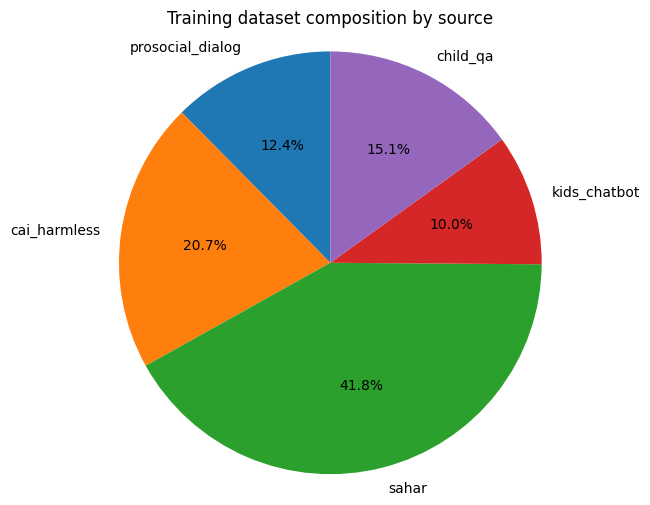

In [7]:
from collections import Counter  # reuse Counter for plotting counts
import matplotlib.pyplot as plt  # plotting library

source_counts = Counter(combined_ds[config["source_field"]])  # compute counts per source
print("Counts per source:", source_counts)

labels = list(source_counts.keys())  # labels for pie chart
sizes = [source_counts[label] for label in labels]  # sizes for pie chart

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)  # draw pie chart
ax.set_title("Training dataset composition by source")  # title
ax.axis('equal')  # equal aspect for circle
plt.show()  # display chart


In [9]:
from peft import LoraConfig, get_peft_model  # LoRA utilities

try:  # wrap in try for clarity
    train_processor = AutoProcessor.from_pretrained(config["model_id"])
    train_model = Gemma3ForConditionalGeneration.from_pretrained(
        config["model_id"],  # model id
        device_map="auto",  # automatic placement
        quantization_config=bnb_config,  # reuse 4-bit config
        torch_dtype=dtype  # dtype selection
    )
    lora_config = LoraConfig(  # define LoRA hyperparameters
        r=16,  # rank
        lora_alpha=32,  # scaling
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # target modules
        lora_dropout=0.05,  # dropout for stability
        bias="none",  # do not train biases
        task_type="CAUSAL_LM"  # language modeling task
    )  # end LoRA config
    train_model = get_peft_model(train_model, lora_config)  # apply LoRA to model
    trainable_params = sum(p.numel() for p in train_model.parameters() if p.requires_grad)  # count trainable params
    total_params = sum(p.numel() for p in train_model.parameters())  # count total params
    print(f"Trainable parameters: {trainable_params} / {total_params}")  # report parameter counts
except Exception as lora_error:  # handle LoRA setup issues
    print(f"LoRA setup failed: {lora_error}")
    raise  # re-raise exception

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trainable parameters: 32788480 / 2523011440


In [10]:
def format_example(example):  # convert messages to text prompt
    assert "messages" in example, "Missing messages field"  # ensure key exists
    chat = example["messages"]  # grab chat messages
    formatted = train_processor.apply_chat_template(chat, add_generation_prompt=False, tokenize=False)  # render chat to text
    return {config["text_field"]: formatted}

formatted_ds = combined_ds.map(format_example, remove_columns=combined_ds.column_names)  # apply formatting
print(formatted_ds[0][config["text_field"]][:200])  # preview formatted text snippet

Map:   0%|          | 0/4834 [00:00<?, ? examples/s]

<bos><start_of_turn>user
What the hell is that get all politically correct with me, who are you?<end_of_turn>
<start_of_turn>model
Black people have really suffered for hundreds of years under the sus


In [ ]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments

# Use SFTConfig for trainer arguments
training_args = SFTConfig(
    output_dir="gemma3_child_lora_outputs",
    per_device_train_batch_size=config["train_batch_size"],
    per_device_eval_batch_size=config["eval_batch_size"],
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    learning_rate=config["learning_rate"],
    max_steps=config["max_steps"],
    logging_steps=config["logging_steps"],
    save_steps=config["save_steps"],
    fp16=(dtype == torch.float16),
    bf16=(dtype == torch.bfloat16),
    report_to="none",

    # SFT-specific parameters
    max_length=config["max_seq_length"],
    dataset_text_field=config["text_field"]
)

# Extract the tokenizer from the processor
# SFTTrainer requires direct access to special tokens like 'eos_token'
tokenizer = train_processor.tokenizer

# Ensure a pad_token is set (Gemma sometimes lacks a default one)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Training Arguments Initialized.")

trainer = SFTTrainer(
    model=train_model,
    processing_class=tokenizer,  # FIX: Pass the tokenizer, not the processor
    train_dataset=formatted_ds,
    args=training_args
)

try:
    train_result = trainer.train()

    # Save adapter
    trainer.model.save_pretrained("gemma3_child_friendly_lora")

    # Save the full processor (not just tokenizer) for future multimodal use
    train_processor.save_pretrained("gemma3_child_friendly_lora")

except Exception as train_error:
    print(f"Training failed: {train_error}")
    raise

Training Arguments Initialized.


Adding EOS to train dataset:   0%|          | 0/4834 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4834 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4834 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss
25,2.181800
50,1.260500
75,1.279700
100,1.208300
125,1.150500
150,1.186300


In [ ]:
from peft import PeftModel

try:
    eval_processor = AutoProcessor.from_pretrained(config["model_id"])  # fresh processor
    eval_base_model = Gemma3ForConditionalGeneration.from_pretrained(  # reload base model
        config["model_id"],  # model id
        device_map="auto",  # auto placement
        quantization_config=bnb_config,  # 4-bit config
        torch_dtype=dtype  # dtype
    )
    eval_base_model.eval()  # set eval mode
    eval_ft_model = Gemma3ForConditionalGeneration.from_pretrained(
        config["model_id"],  # model id
        device_map="auto",  # auto placement
        quantization_config=bnb_config,  # 4-bit config
        torch_dtype=dtype  # dtype
    )
    eval_ft_model = PeftModel.from_pretrained(eval_ft_model, "gemma3_child_friendly_lora")  # attach LoRA adapter
    eval_ft_model.eval()  # set eval mode
    print("Reloaded base and fine-tuned models for evaluation.")  # confirmation
except Exception as reload_error:  # handle reload failures
    print(f"Model reload failed: {reload_error}")  # show error
    raise  # propagate error

In [ ]:

def generate_responses(model, processor, prompts, max_new_tokens=128):
    """Generate chat completions for a list of prompts.

    Keeps the template consistent between base and fine-tuned runs so toxicity comparisons are fair.
    """
    outputs = []
    for prompt in prompts:
        # 1. Structure the message
        messages = [
            {"role": "user", "content": [{"type": "text", "text": str(prompt)}]},
            {"role": "assistant", "content": [{"type": "text", "text": ""}]}
        ]

        prompt_text = processor.tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False
        )

        # 3. Process the string into tensors
        inputs = processor(
            text=prompt_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048
        ).to(model.device)  # Move the entire batch encoding to GPU

        with torch.no_grad():
            generation = model.generate(**inputs, max_new_tokens=max_new_tokens)

        decoded = processor.batch_decode(generation, skip_special_tokens=True)[0]
        outputs.append(decoded)

    return outputs


In [ ]:
child_prompt = "Why do stars sparkle at night?"

print("### Base model (google/gemma-3-4b-it)")
base_full_response = generate_responses(eval_base_model, eval_processor, [child_prompt], max_new_tokens=512)[0]
print(base_full_response)

In [ ]:
print("\n### Fine-tuned model (with LoRA adapter)")
ft_full_response = generate_responses(eval_ft_model, eval_processor, [child_prompt], max_new_tokens=512)[0]
print(ft_full_response)